## Importing Libraries

In [55]:
#
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix ,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

### Loading Data

In [41]:
# downloading dataset from kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip /content/toronto-emotional-speech-set-tess.zip -d /content/tessdata/

In [5]:
!mv '/content/tessdata/TESS Toronto emotional speech set data/YAF_pleasant_surprised' '/content/tessdata/TESS Toronto emotional speech set data/surprise'

In [6]:
dir_path = '/content/tessdata/TESS Toronto emotional speech set data'
lst = os.listdir(dir_path)
lst

['YAF_sad',
 'YAF_angry',
 'OAF_Fear',
 'YAF_fear',
 'OAF_neutral',
 'OAF_angry',
 'YAF_neutral',
 'OAF_Pleasant_surprise',
 'OAF_disgust',
 'surprise',
 'YAF_happy',
 'OAF_Sad',
 'YAF_disgust',
 'OAF_happy']

In [7]:
def load_data(dir_path):
  path, labels = [], []
  for label in os.listdir(dir_path):
    for file in os.listdir(os.path.join(dir_path, label)):
      path.append(os.path.join(dir_path, label, file))
      labels.append(label.split('_')[-1].lower())
  return path, labels

In [79]:
path, labels = load_data(dir_path)
print(set(labels))

{'disgust', 'fear', 'sad', 'neutral', 'angry', 'happy', 'surprise'}


In [9]:
df = pd.DataFrame()
df['path'] = path
df['label'] = labels
df.sample(5)

,path,label
2648,/content/tessdata/TESS Toronto emotional speec...,happy
1024,/content/tessdata/TESS Toronto emotional speec...,angry
2541,/content/tessdata/TESS Toronto emotional speec...,disgust
1681,/content/tessdata/TESS Toronto emotional speec...,disgust
1886,/content/tessdata/TESS Toronto emotional speec...,surprise


In [10]:
df['label'].value_counts()

,count
label,
sad,400
angry,400
fear,400
neutral,400
surprise,400
disgust,400
happy,400


In [11]:
# number of output labels
n_labels = len(df['label'].unique())
n_labels

7

### Data Analysis

<Axes: ylabel='count'>

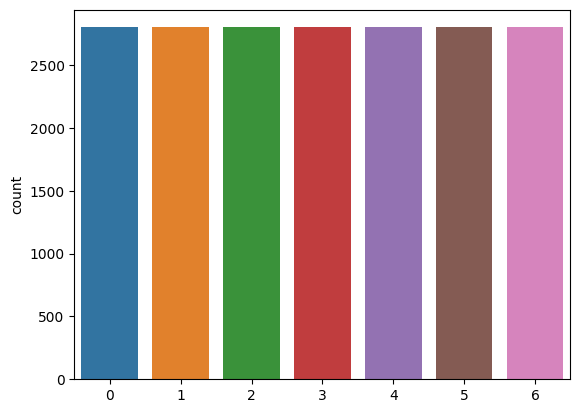

In [12]:
#Graphical Representation
le = LabelEncoder()
labels_encoded = to_categorical(le.fit_transform(labels))
sns.countplot(data=labels_encoded)

In [13]:
labels_encoded.shape

(2800, 7)

In [14]:
def waveplot(data, sr, emotion): #showing waveplot
  plt.figure(figsize=(10, 4))
  plt.title(emotion + " waveplot", size=20)
  librosa.display.waveshow(data, sr=sr)
  plt.show()

def spectogram(data, sr, emotion): #showing spectogram
  x = librosa.stft(data)
  xdb=librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(11,4))
  plt.title(emotion + " spectogram",size=20 )
  librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
  plt.colorbar()

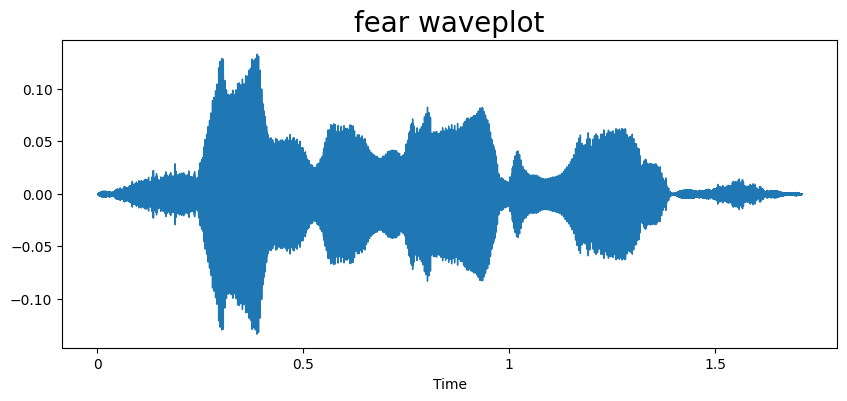

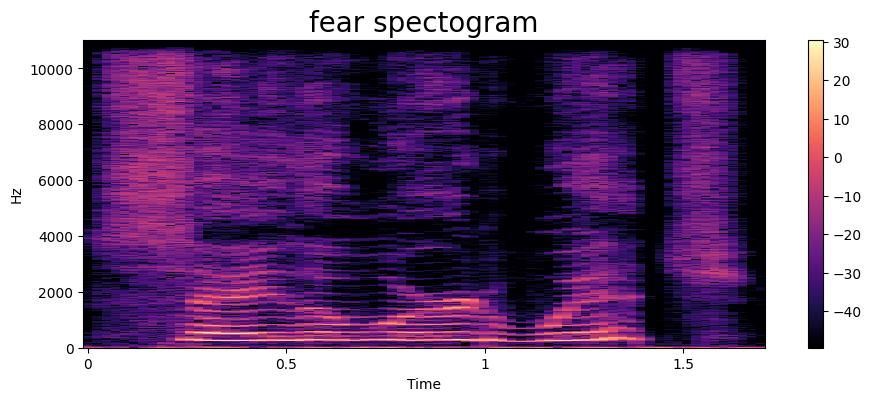

In [69]:
emotion='fear'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path) #PLAY

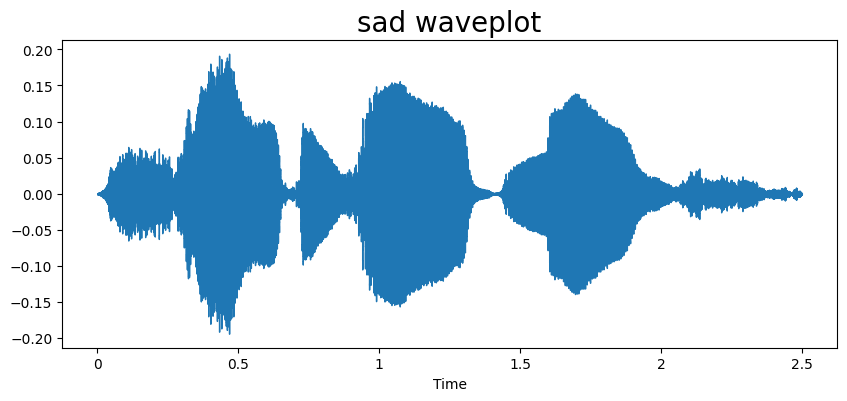

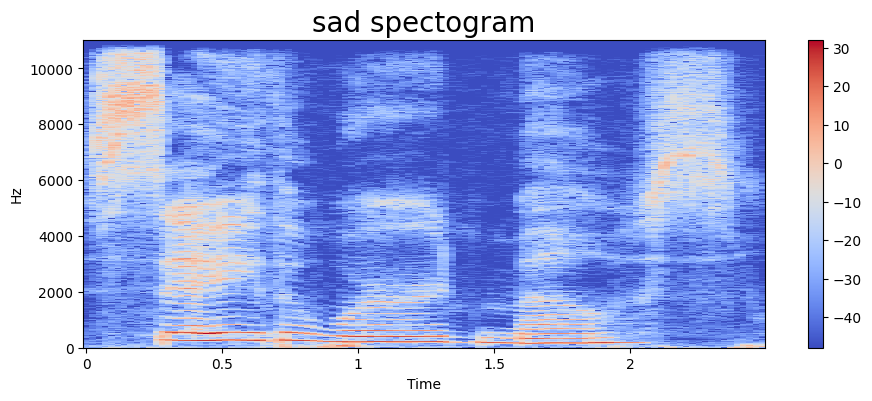

In [70]:
emotion='sad'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

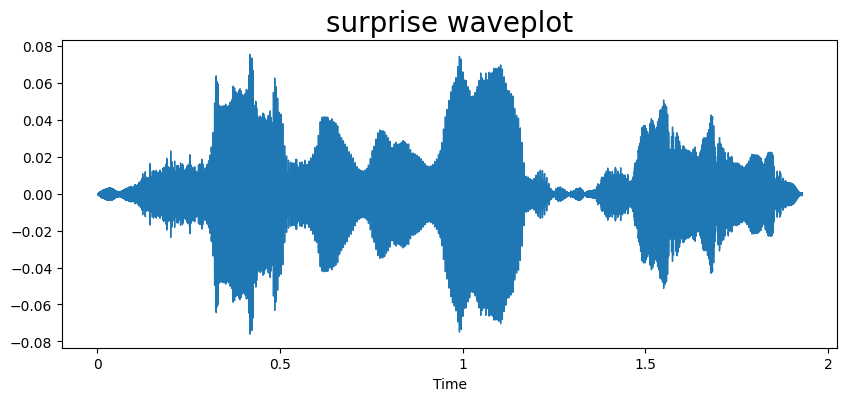

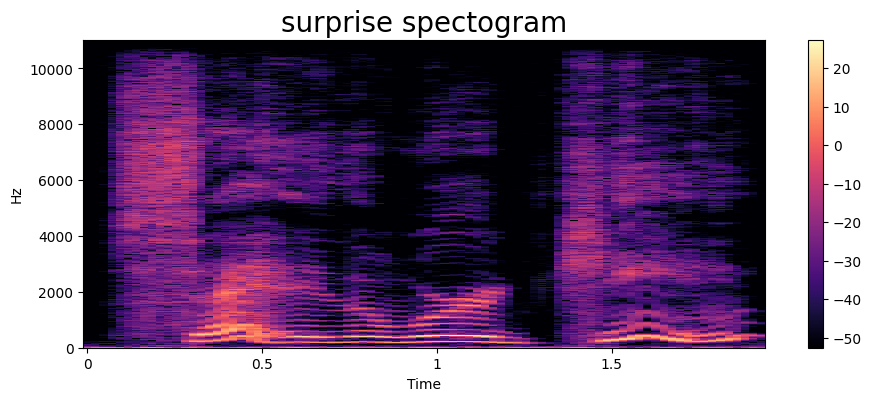

In [77]:
emotion='surprise'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

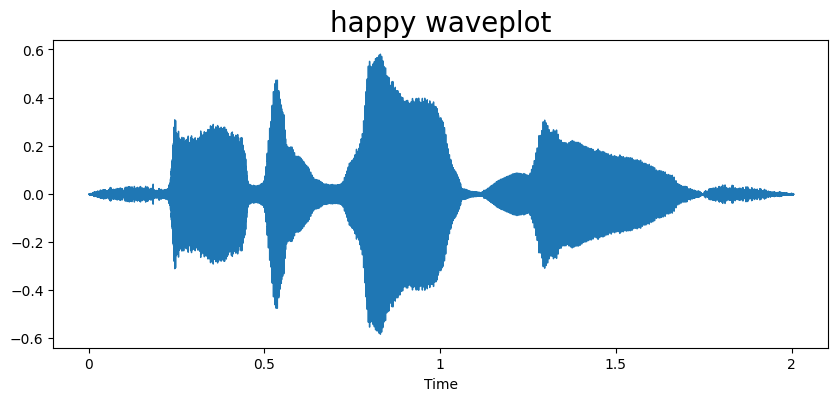

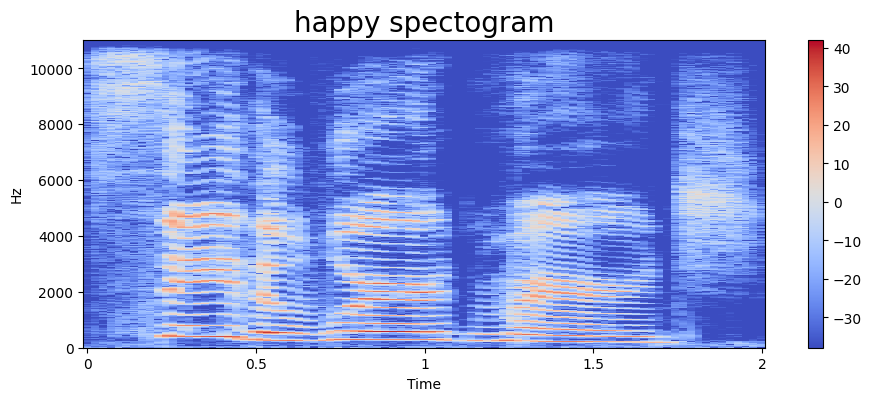

In [72]:
emotion='happy'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

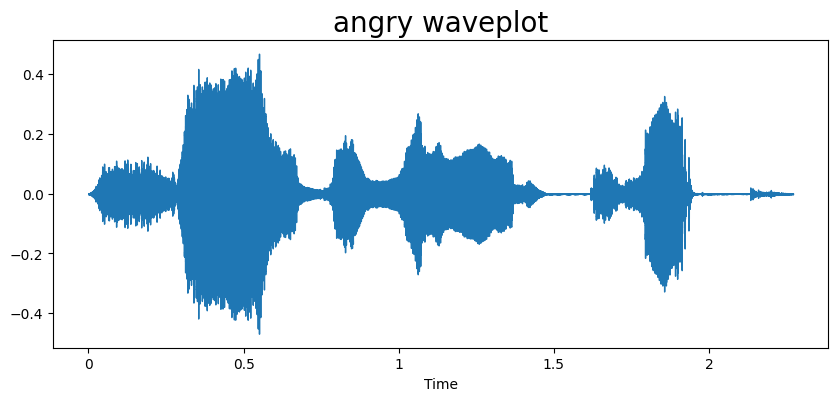

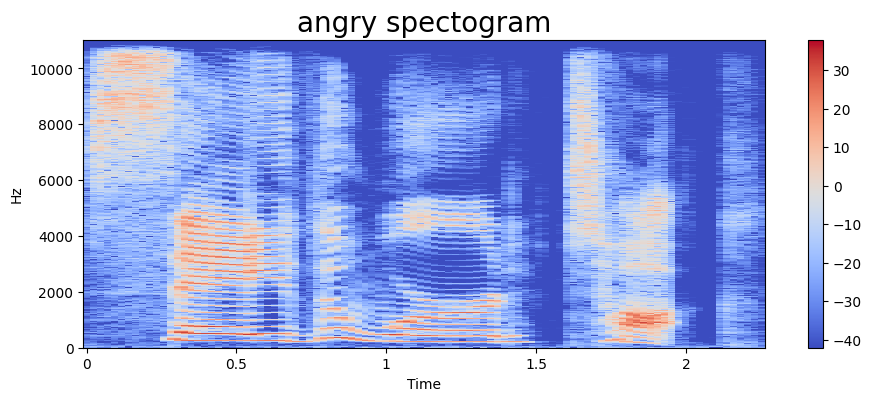

In [78]:
emotion='angry'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

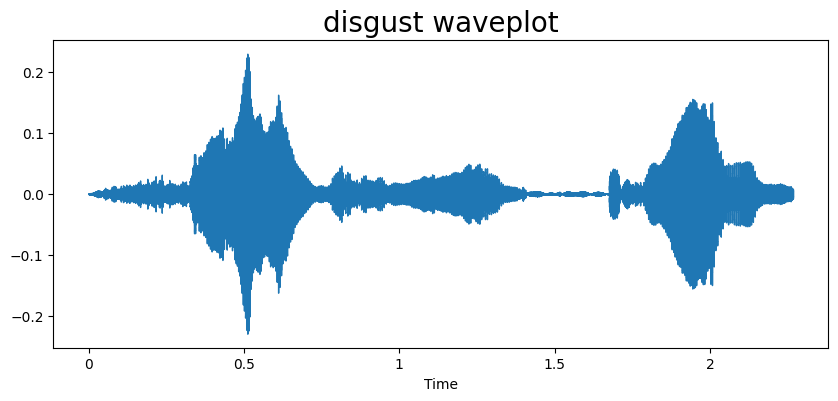

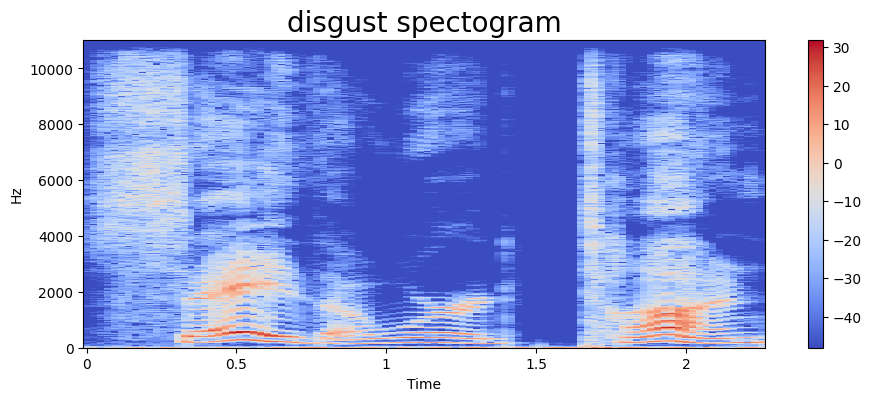

In [46]:
emotion='disgust'
file_path=np.array(df['path'][df['label']==emotion])[0]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

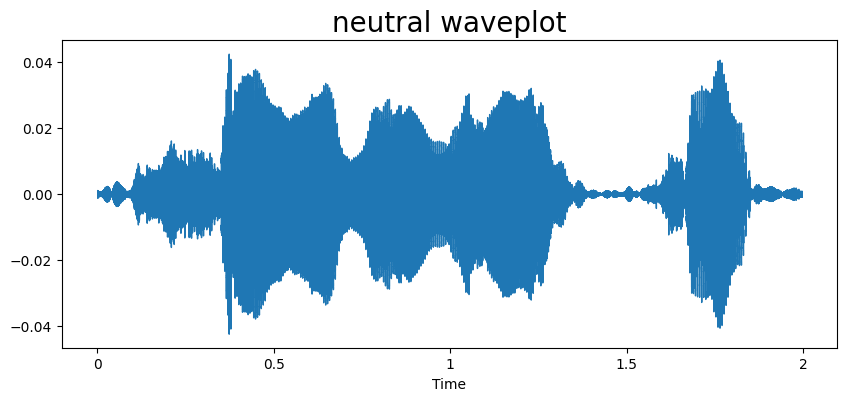

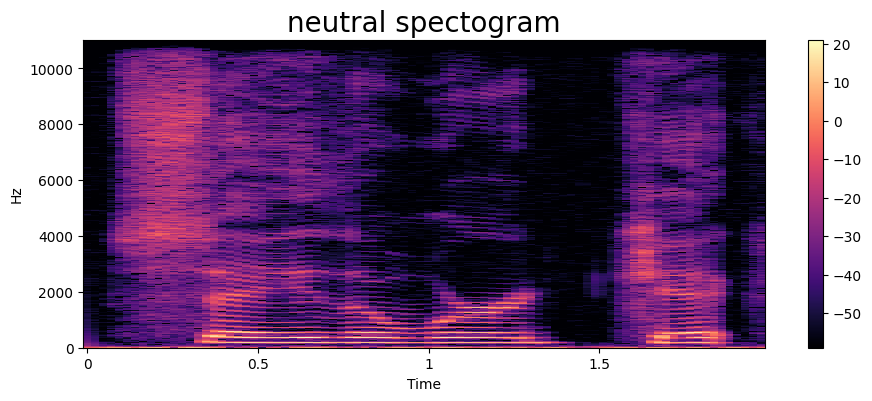

In [48]:
emotion='neutral'
file_path=np.array(df['path'][df['label']==emotion])[5]
signal, sr = librosa.load(file_path)
waveplot(signal, sr, emotion)
spectogram(signal, sr, emotion)
Audio(file_path)

## Feature Extraction (help to fetch features from audio)

In [22]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)
    return mfcc

In [23]:
X_mfcc=df['path'].apply(lambda x: extract_mfcc(x))

In [71]:

X=np.array(X_mfcc.tolist())
X.shape

(2800, 40)

In [25]:
X=np.expand_dims(X,-1)
print(X.dtype)
X.shape

float32


(2800, 40, 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, labels_encoded, test_size=0.2, random_state=42)

In [27]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [28]:
# Construct  Architecture
model = Sequential()
model.add(LSTM(150))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
history = model.fit(X_train, y_train, epochs=30, batch_size=10, validation_split=0.2)  #training the model
model.save('speech_recog_model.keras')

Epoch 1/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4499 - loss: 1.3979 - val_accuracy: 0.7835 - val_loss: 0.6852
Epoch 2/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7909 - loss: 0.5992 - val_accuracy: 0.9420 - val_loss: 0.2490
Epoch 3/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9069 - loss: 0.3337 - val_accuracy: 0.9487 - val_loss: 0.1595
Epoch 4/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9368 - loss: 0.2008 - val_accuracy: 0.9576 - val_loss: 0.1363
Epoch 5/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9160 - loss: 0.2688 - val_accuracy: 0.9420 - val_loss: 0.1753
Epoch 6/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9499 - loss: 0.1787 - val_accuracy: 0.9621 - val_loss: 0.1248
Epoch 7/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9576 - loss: 0.1607 - val_accuracy: 0.9263 - val_loss: 0.2164
Epoch 8/30
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9641 - loss: 0.1354 - val_accuracy: 0

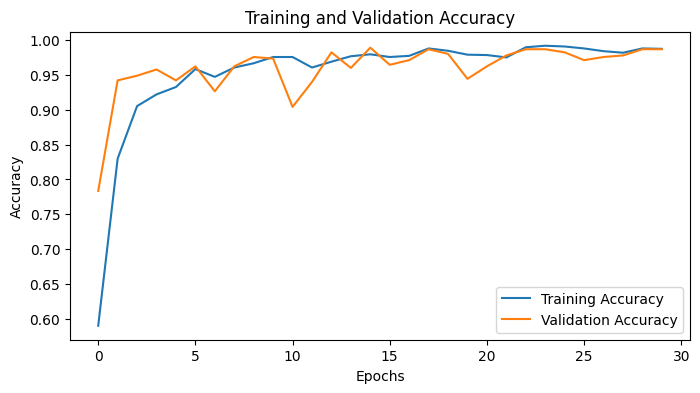

In [76]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

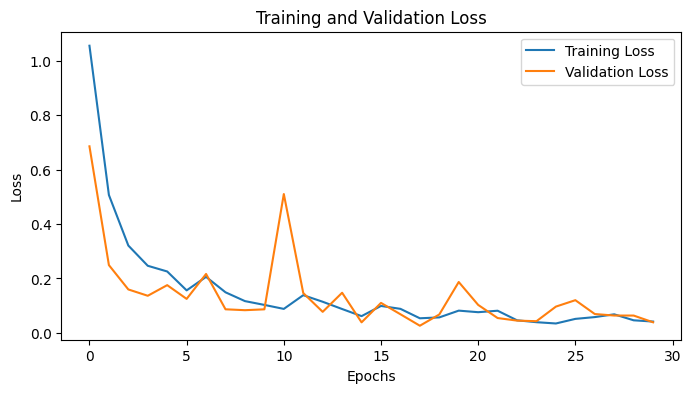

In [75]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

In [49]:

print(X_test.shape)
print(X_train.shape)

(560, 40, 1)
(2240, 40, 1)


In [33]:
X_test = X_test.reshape(-1, 40, 1)
pred_y = model.predict(X_test)
pred_y.shape

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


(560, 7)

In [34]:
pred_y = np.argmax(pred_y, axis = 1)
test_y = np.argmax(y_test, axis = 1)

In [52]:
# Accuracy Score

AS = accuracy_score(pred_y, test_y)

print("Accuracy Score --> ", AS)
print("\n")
print("Accuracy Score as Percentage -->  ", AS * 100,"%")

Accuracy Score -->  0.9767857142857143


Accuracy Score as Percentage -->   97.67857142857143 %


##  Confusion Matrix

In [36]:
# Confusion Matrix
Conf_Matrix = confusion_matrix(pred_y, test_y)
print("Confusion Matrix:\n", Conf_Matrix)

Confusion Matrix:
 [[82  0  0  1  0  0  0]
 [ 3 77  1  2  0  1  1]
 [ 0  0 88  0  0  0  0]
 [ 0  0  0 70  0  0  1]
 [ 0  0  0  0 79  0  0]
 [ 0  0  0  0  0 79  0]
 [ 1  2  0  0  0  0 72]]


Text(0.5, 1.0, 'Confusion Matrix')

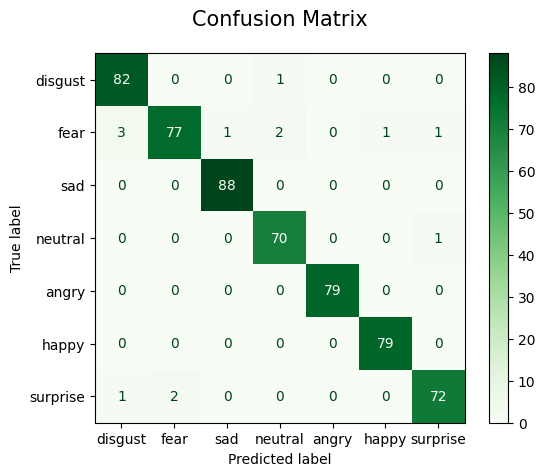

In [74]:
#{'disgust', 'fear', 'sad', 'neutral', 'angry', 'happy', 'surprise'}
target_names = ['disgust', 'fear', 'sad', 'neutral', 'angry', 'happy', 'surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=Conf_Matrix , display_labels=target_names)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix', fontsize=15, pad=20)

## Classification Report

In [68]:
Target_Emotions = ['disgust', 'fear', 'sad', 'neutral', 'angry', 'happy', 'surprise']

CR = classification_report(pred_y, test_y, target_names = Target_Emotions)

print("Classification Report:\n", CR)

Classification Report:
               precision    recall  f1-score   support

     disgust       0.95      0.99      0.97        83
        fear       0.97      0.91      0.94        85
         sad       0.99      1.00      0.99        88
     neutral       0.96      0.99      0.97        71
       angry       1.00      1.00      1.00        79
       happy       0.99      1.00      0.99        79
    surprise       0.97      0.96      0.97        75

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560

